# Coherence of GJ3942

### Important Note

Change the path in <tt>sys.path.insert()</tt> to wherever the <tt>NWelch</tt> source code resides on your machine.

Coherences were made for RVT & H$\alpha$, RVY & H$\alpha$, S Index & H$\alpha$, and S Index & RVT.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

import sys
sys.path.insert(0, '/Users/andrewandmatthewfonseca/NWelch/src/')

import TimeSeries
import Bivariate as Bi

### GJ3942's dataset

These are the GJ3942's star activity indicators reported by <a href="https://arxiv.org/pdf/1709.06851.pdf">Perger et al. (2021)</a>.

In [4]:
data = pd.read_csv('GJ3942_HARPSN_Perger17.txt', delim_whitespace=True, comment='#')
data
# Excluded 3 rows for irrelevant data (rows with -999)

BJD     RVT  e_RVT        RVY  e_RVY  drift  e_drift   SNR      S  \
0     438.5877   0.613  1.113 -18708.988  1.549  0.000    1.025  67.7  1.793   
1     440.5944  -8.092  0.812 -18711.672  1.333  0.000    1.025  80.2  1.898   
2     442.5249  -3.829  0.797 -18708.737  1.146  0.000    1.025  93.4  1.994   
3     443.4686  -6.004  1.134 -18710.886  2.064  0.000    1.025  52.0  2.088   
4     444.4712  -6.527  0.941 -18711.617  1.468  0.000    1.025  72.3  1.784   
..         ...     ...    ...        ...    ...    ...      ...   ...    ...   
137  1629.3893   5.080  1.172 -18699.319  1.628  0.150    0.074  63.6  1.778   
138  1630.3921  -2.377  1.282 -18711.553  2.206  0.162    0.074  46.7  1.804   
139  1632.3916 -12.258  1.120 -18716.701  1.601  0.180    0.074  63.4  1.786   
140  1638.3967   2.587  1.081 -18703.416  1.758 -1.298    0.074  57.5  1.529   
141  1642.3937   1.767  1.152 -18700.358  1.719 -0.065    0.074  59.7  1.740   

       e_S  Halpha  e_Halpha  Notes  
0    0.042   6.276     0.102      3  
1    0.060   6.420     0.102      3  
2    0.082   6.545     0.103      3  
3    0.028   6.697     0.104      3  
4    0.047   6.308     0.102      3  
..     ...     ...       ...    ...  
137  0.041   6.310     0.106      1  
138  0.025   6.405     0.110      1  
139  0.041   6.386     0.103      1  
140  0.035   6.005     0.102      1  
141  0.037   6.326     0.103      1  

[142 rows x 13 columns]

In [5]:
# Stellar signals (planet and rotations)
pb = 6.9 # 6.9 days (plant signal)
pc = 10.4 # 10.4 days (possible second planet from Perger paper)
prot1 = 16.3 # 16.3 day rotation period (from paper)
prot2 = 32 # 32 day rotation period

In [6]:
# Fonts and Sizes
title_font = 18
label_font = 14
text_font = 12

<font size=10><p style="text-align:center"> RVT & H$\alpha$ </font></p>

### RVT & H$\alpha$ TimeSeries Objects

Creating TimeSeries objects and outputing various estimates of the Nyquist-like frequency, which is the highest frequency about which your data contain reliable information. The Rayleigh resolution is the lowest frequency about which your time series contains information. Prints the number of rows in the dataset, which will be used later for fake data iteration.

In [7]:
ha = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['Halpha'].to_numpy())
rvt = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['RVT'].to_numpy(), display_frequency_info=False)
print("# of rows in dataset: ", ha.N)

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083
# of rows in dataset:  142


### Plotting the RVT & H$\alpha$ data

Creating scatterplots of each TimeSeries object. Creating $\Delta$t historgram of RVT ($\Delta$$t_{i}$ = $t_{i+1}$ - $t_{i}$). Examining the $\Delta$t histogram can help you choose a sensible Nyquist-like frequency for your periodograms.

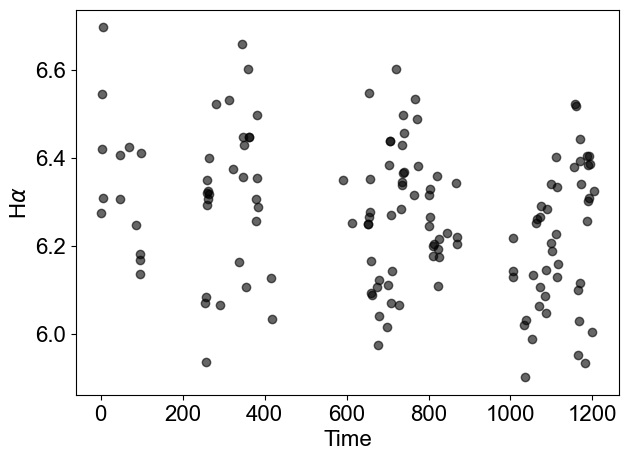

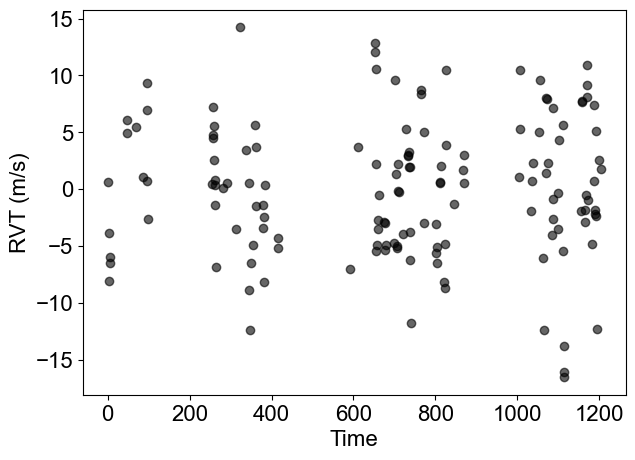

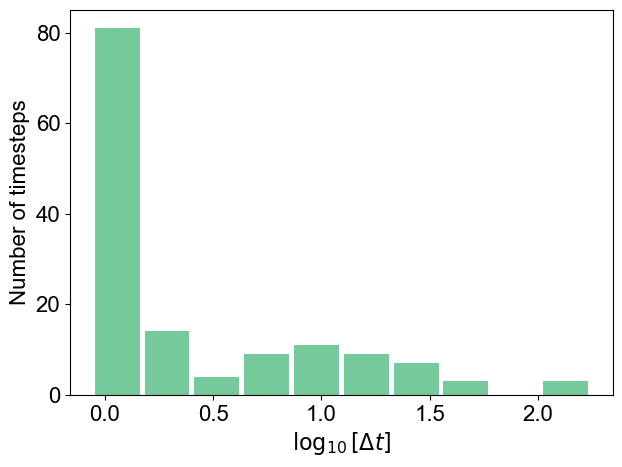

In [8]:
ha.scatterplot(ylabel=r"H$\alpha$")
rvt.scatterplot(ylabel="RVT (m/s)")
rvt.dthist()

### Frequency grid for the Lomb-Scargle periodogram of RVT & H$\alpha$

This software separates frequency-grid construction and periodogram calculation into two different functions. This is so the user has to make a conscious decision about which frequencies it makes sense to probe.
<br>Also running the untapered periodgram of a non-uniform fast Fourier Transform for each TimeSeries objects at 2000 bootstrap iterations.

In [9]:
ha.frequency_grid(0.2)
rvt.frequency_grid(0.2)

ha.pow_FT(N_bootstrap=2000)
rvt.pow_FT(N_bootstrap=2000)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


### Plot the periodograms of RVT & H$\alpha$

Vertical lines mark the rotation period on the H$\alpha$ periodogram of GJ 3942, and planets b and a second possible planet on the RVT periodogram. The rotation period of ~16 days is what we have measured from this analysis. Further anaylsis shows that a possible rotation period for the star is ~32 days due to only tracking to one spot on the star, rather then the entire rotational period.

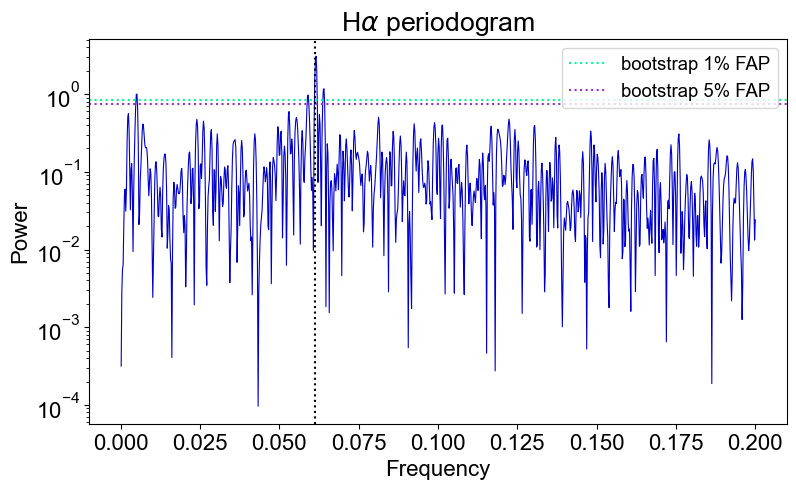

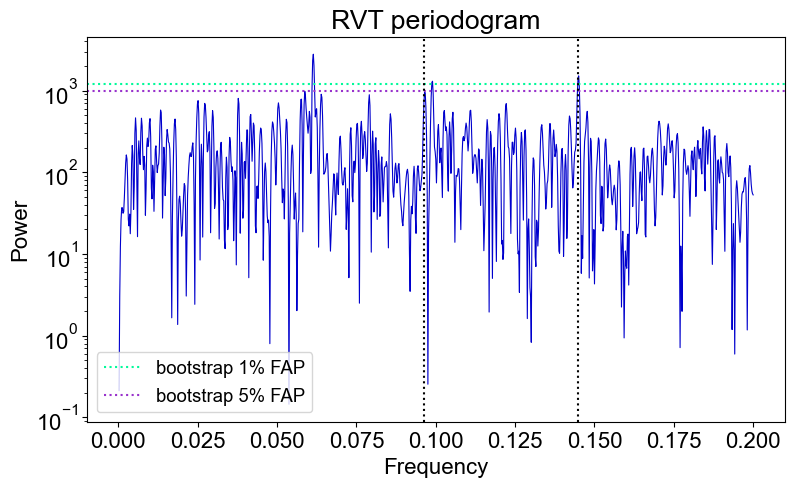

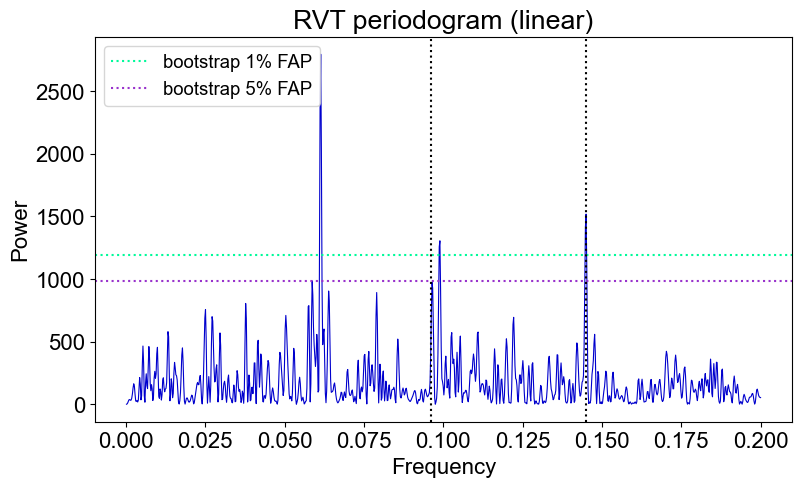

In [10]:
planets = [1/pb, 1/pc]
rotation = [1/prot1]

ha.powplot(title=r"H$\alpha$ periodogram", vlines=rotation)
rvt.powplot(title='RVT periodogram', vlines=planets)
rvt.powplot(title='RVT periodogram (linear)', vlines=planets, yscale='linear')

### Siegel's test for periodicity of RVT & H$\alpha$

Here we use the conservative implementation with $\lambda = 0.6$, which is optimized for two periodic signals.

In [11]:
rvt.Siegel_test()
ha.Siegel_test()

T statistic: 0.03043
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.07189
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


### Start the coherence analysis of RVT & H$\alpha$

We start by creating the Bivariate object, which is defined below.

In [12]:
rvt_ha = Bi.Bivariate(data['BJD'].to_numpy(), data['RVT'].to_numpy(), data['Halpha'].to_numpy())

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


### Set up the Welch's segmenting and tapering scheme from RVT & H$\alpha$

This is the segmenting and tapering of RVT & H$\alpha$. This gives information on Rayleigh resolution and power spectrum resolution unit, related to the spectral window. I used the taper 'BlackmanHarris' in segmenting this data to get the bell-shaped figures below. Tapering decreases your spectral resolution but helps to supress variance, which is effective for planet searching.

Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152
Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152


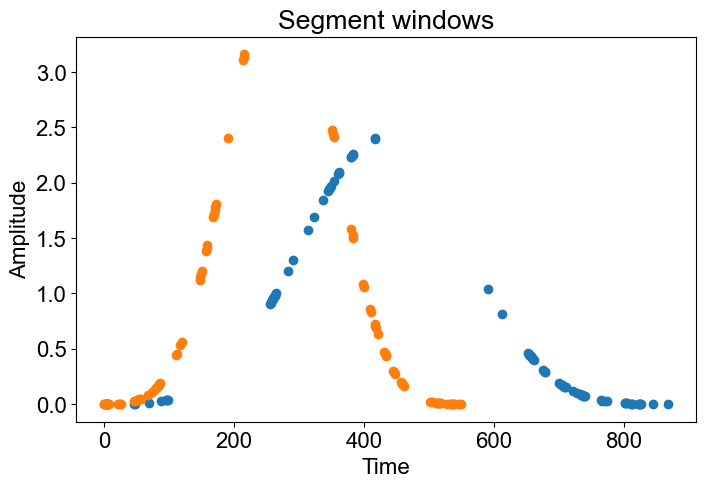

In [13]:
rvt_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

### Calculating the RVT & H$\alpha$ coherence estimate, Welch's power spectrum estimates, and bootstrap false alarm levels

You would want zero background coherence when computing analytical false alarm levels on coherence stimates. boostrap helps with this, as they act as a fialsafe for when the analytical false alarm levels fail, which doesn't happen very often. In calculating the power spectrum estimates, 10000 iterations are used.

In [14]:
rvt_ha.Welch_coherence_powspec()
rvt_ha.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.180
1% FAP: 0.071
0.1% FAP: 0.011

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.196 crossings =  65.1050 %ile
1% FAP: 0.092 crossings =  77.9750 %ile
0.1% FAP: 0.000 crossings =  65.1050 %ile



### Using Siegel's test on the Welch's power spectrum estimates for RVT & H$\alpha$

<tt>Bivariate.Siegel_Welch()</tt> is actually just a wrapper of <tt>TimeSeries.Siegel_test(Welch=True)</tt>.

As expected, the Welch's power spectrum estimates support the hypothesis that both time series are periodic.

In [15]:
rvt_ha.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00952
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


### Plotting the magnitude-squared coherence estimate from RVT & H$\alpha$

The vertical lines show the stellar signals mentioned before, which are the star rotational period, planet b, and a possible second planet. The [paper](https://doi.org/10.1051/0004-6361/201731307) on GJ 3942 shows a recorded rotational period of roughly 16 days. The coherence plots show the debiased coherence estimate. 'pd' and 'pg' are the frequncies of planet b and the possible second planet, which are the vertial lines on the plot.

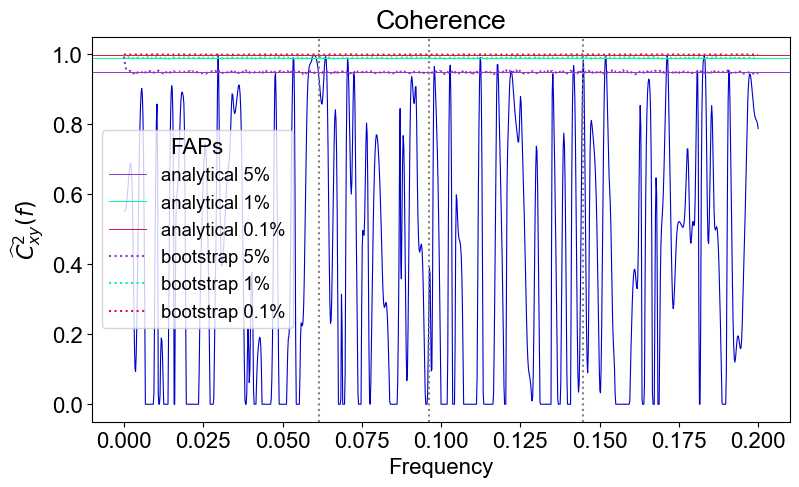

In [16]:
stellar_signals = [1/prot1, 1/pb, 1/pc]
rvt_ha.coh_plot(show_theoretical_thresholds=True, vlines=stellar_signals)

### Plot the transformed coherence estimate $z(f)$ for RVT & H$\alpha$

In this plot of the transformed coherence estimate $z(f)$, we can see the stellar signals mentioned before. There is significance at the rotational period of 16 days for GJ 3942, but there is an equal amount of significance at a rotational period of 32 days, hinting at a discrepancy. There is also some significance at the signal for planet b, and non-significant activity at the signal for a possible second planet. At this point, it seems safe to rule out the possible second planet, as there isn't enough substantial data to validate its existance. 

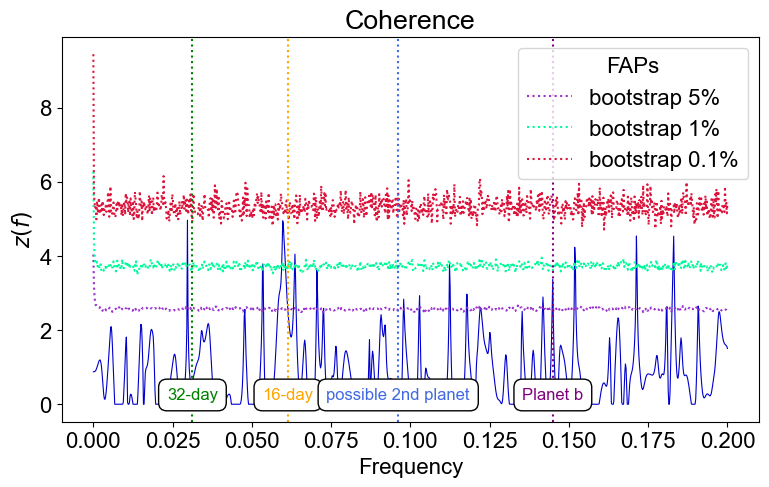

In [17]:
rvt_ha.coh_plot(transformed=True)

# Adjust the figure size and re-draw figure
plt.gcf().set_size_inches(9, 5)
plt.draw()

# Vertical lines for planet frequencies and rotation periods
plt.axvline(1/prot1, color='orange', ls=':') # 16-day rotation period vline
plt.axvline(1/prot2, color='green', ls=':') # 32-day rotation period vline
plt.axvline(1/pb, color='purple', ls=':') # planet b frequency vline
plt.axvline(1/pc, color='royalblue', ls=':') # possible second planet frequency vline

# Vertical line text labels
plt.text(1/prot1, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, '16-day', color='orange', fontsize=text_font, 
         verticalalignment='bottom', horizontalalignment='center', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(1/prot2, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, '32-day', color='green', fontsize=text_font, 
         verticalalignment='bottom', horizontalalignment='center', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(1/pb, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'Planet b', color='purple', fontsize=text_font, 
         verticalalignment='bottom', horizontalalignment='center', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.text(1/pc, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, 'possible 2nd planet', color='royalblue', fontsize=text_font, 
         verticalalignment='bottom', horizontalalignment='center', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.legend(title='FAPs', loc='upper right')
# plt.axvline(5/prot, color='mediumspringgreen', ls=':')
# Instead of moving the legend outside the plot, create a two-column legend
# Include what each vline is for each signal (planet signals, 16-day signal, 32-day signal, etc.)

### Examine the Welch's spectral window of RVT & H$\alpha$

Since a <tt>Bivariate</tt> object stores the data in two <tt>TimeSeries</tt> objects, <tt>x_series</tt> and <tt>y_series</tt>, you have access to all the <tt>TimeSeries</tt> methods. Here we use <tt>TimeSeries.spectral_window_Welch()</tt> to sanity-check our Welch's spectral window and make sure it has no huge sidelobes that can easily be misinterpreted as periodic signals.

Half bandwidth: 0.001734
Welch average spectral window not saved to file
Half bandwidth: 0.001734
Welch average spectral window not saved to file


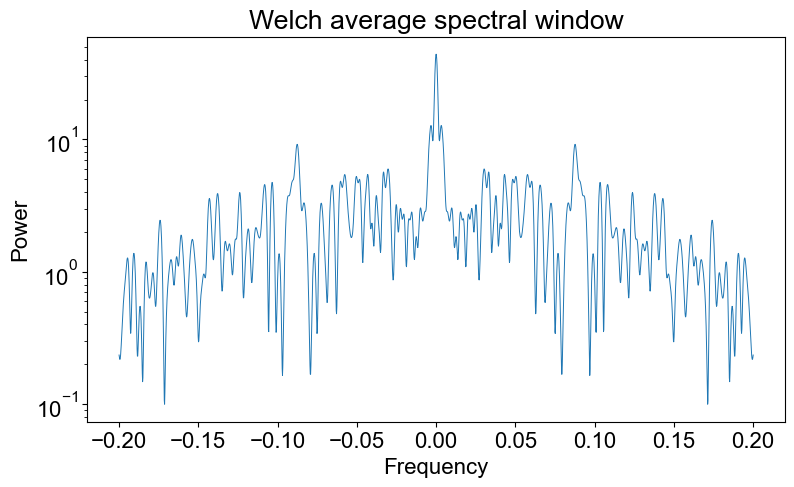

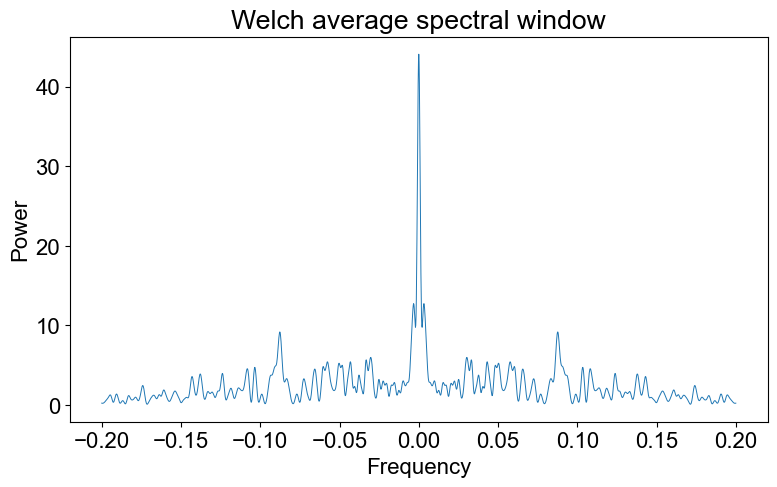

In [14]:
rvt_ha.x_series.spectral_window_Welch()
rvt_ha.x_series.spectral_window_Welch(yscale='linear')

### Plot both Welch's power spectrum estimates of RVT & H$\alpha$

<tt>Bivariate.Welch_pow_plot()</tt> is a wrapper of <tt>TimeSeries.powplot(Welch=True)</tt>. The first plot is of a Welch power plot of RVT, while the second plot is of a Welch power plot of H$\alpha$. Both plots contain the signals for the planets, while the H$\alpha$ plot has all stellar signals. We can see further validation of our previous observations, with equal significance at a rotational period of 16 days and 32 days.

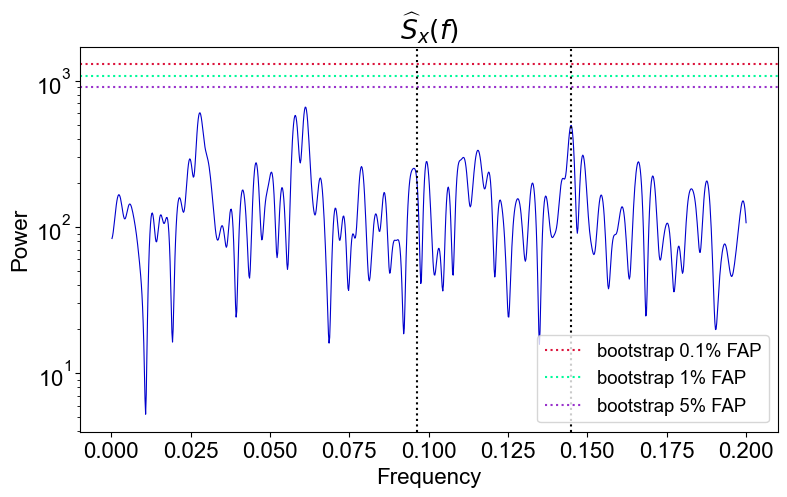

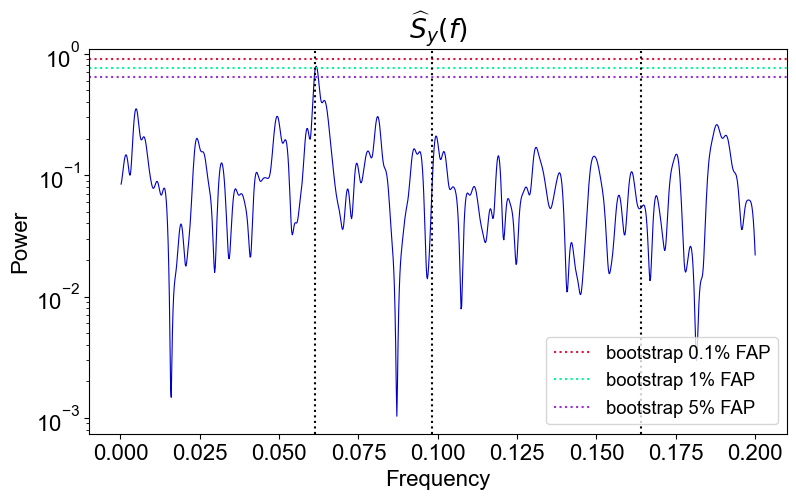

In [15]:
rvt_ha.Welch_pow_plot(vlines=planets)
rvt_ha.Welch_pow_plot(x_or_y='y', vlines=stellar_signals)

### Plot RVT power spectrum with a linear y-axis

This plot is similar to $\hat{S}_{x}(f)$, but with a linear y scale. This plot more easily shows the significance around the stellar signals of the planets, as well as the rotational period of GJ 3942.

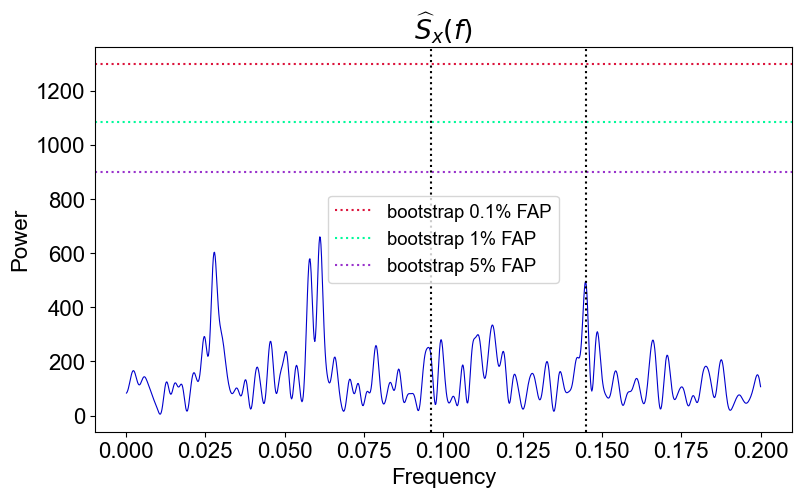

In [16]:
rvt_ha.Welch_pow_plot(vlines=planets, yscale='linear')

### Calculate <tt>astropy.timeseries.LombScargle</tt> periodograms from both time series

Here we specify the same frequency grid as in the previous analysis and use the power spectral density normalization so we can compare with the <tt>NWelch</tt> results, all of which are psd normalized. The zero frequency is responsible for the invalid value warning.

In [17]:
pow_ha = LombScargle(data['BJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rvt_ha.pow_coh_grid)
pow_rvt = LombScargle(data['BJD'].to_numpy(), data['RVT'].to_numpy(), normalization='psd').power(rvt_ha.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


### Rotation period measurement of GJ 3942

Based on the highest peak in the H$\alpha$ Welch's periodogram, which is statistically significant, so the rotational period can be infered to be 16 days, as shown below. From analysis of the coherence plot, this doesn't seem to be cut and dry, so further analysis would be needed to get a better picture of this star's rotational period.

In [18]:
frot_measured = rvt_ha.y_series.Welch_powgrid[np.argmax(rvt_ha.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 16.21875


### Plots of each Welch's periodogram by itself using RVT & H$\alpha$

In the Welch's periodogram for RVT, we can see a significant spike to the left of the rotational period of GJ 3942, implying that there are two spots when recording GJ 3942. This means that when recording the rotational period of GJ 3942, only one half of the star was recorded, and the actual rotational period would be about 32 days. Further analysis would be necessary to better validate this.

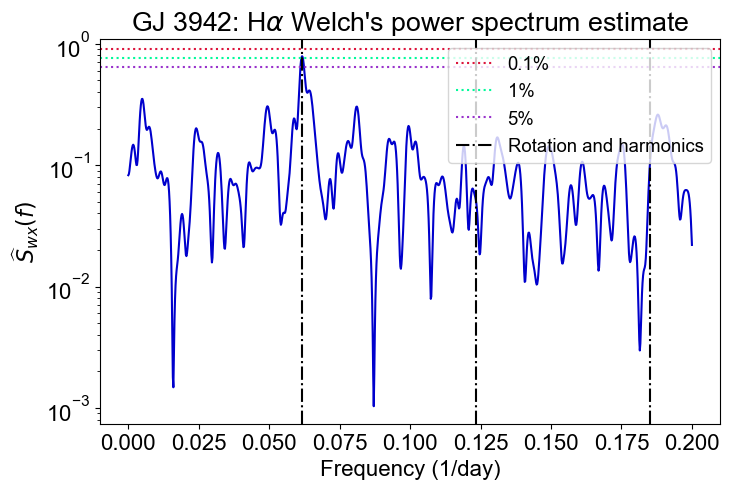

In [19]:
plt.figure(figsize=(8,5))
plt.semilogy(rvt_ha.pow_coh_grid, rvt_ha.y_series.Welch_pow, color='mediumblue')
plt.axhline(rvt_ha.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rvt_ha.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rvt_ha.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
plt.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"GJ 3942: H$\alpha$ Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

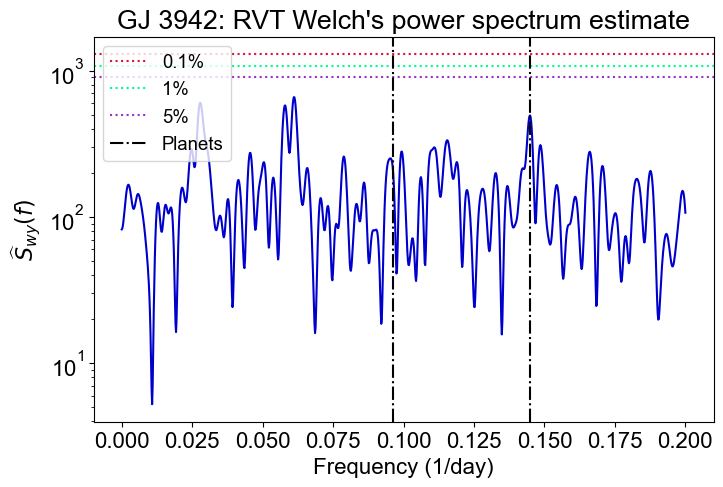

In [20]:
plt.figure(figsize=(8,5))
plt.semilogy(rvt_ha.pow_coh_grid, rvt_ha.x_series.Welch_pow, color='mediumblue')
plt.axhline(rvt_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rvt_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rvt_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
plt.axvline(planets[0], color='k', ls='-.', label='Planets')
plt.axvline(planets[1], color='k', ls='-.')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"GJ 3942: RVT Welch's power spectrum estimate")
plt.legend(loc='upper left', fontsize='small')

### Further Analysis of GJ 3942 Data

To better validate assumptions made, we would need to look at more data pertaining GJ 3942. This can be done by gathering results that support what was found when comparing RVT to H$\alpha$. I compared RVY to H$\alpha$, S Index to H$\alpha$, and S Index to RVT. RVT is the found to be the best set of data due to the type of pipeline that was used, so I used it first to begin my analysis. The comparison are found below and can be found to support claims made in the compasion between RVY and H$\alpha$, following the same procedure used to find time series, power spectrum, coherence, etc.

<font size=10><p style="text-align:center"> RVY & H$\alpha$ </font></p>

In [21]:
ha = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['Halpha'].to_numpy())
rvy = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['RVY'].to_numpy(), display_frequency_info=False)

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


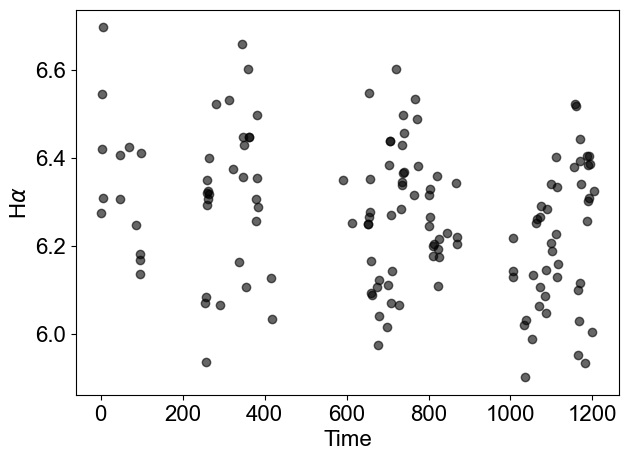

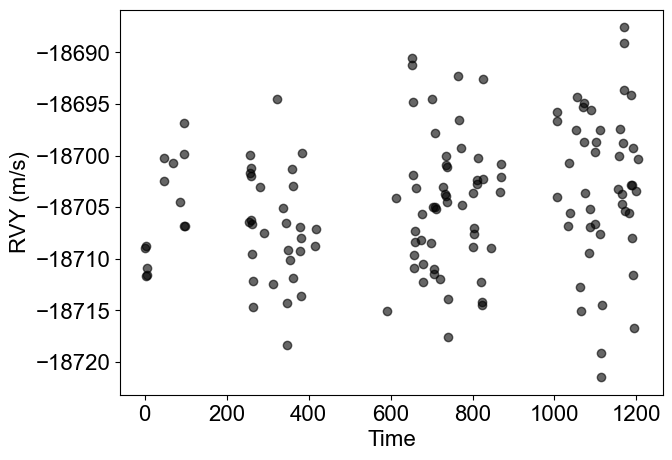

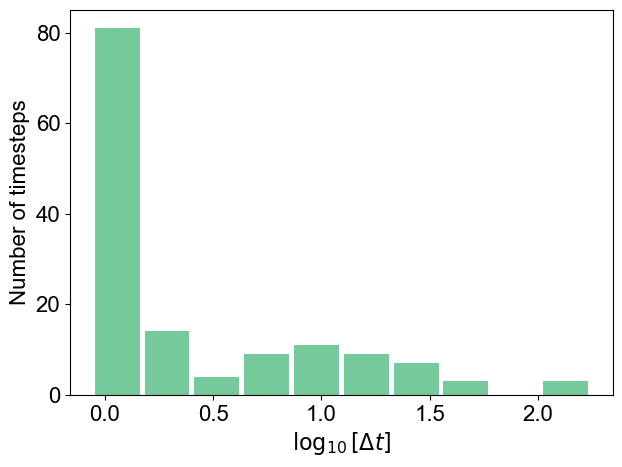

In [22]:
ha.scatterplot(ylabel=r"H$\alpha$")
rvy.scatterplot(ylabel="RVY (m/s)")
rvy.dthist()

In [23]:
ha.frequency_grid(0.2)
rvy.frequency_grid(0.2)

ha.pow_FT(N_bootstrap=2000)
rvy.pow_FT(N_bootstrap=2000)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


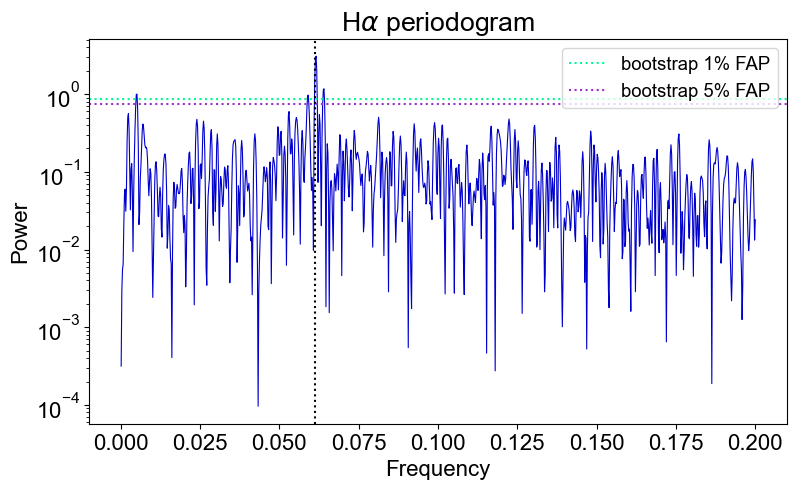

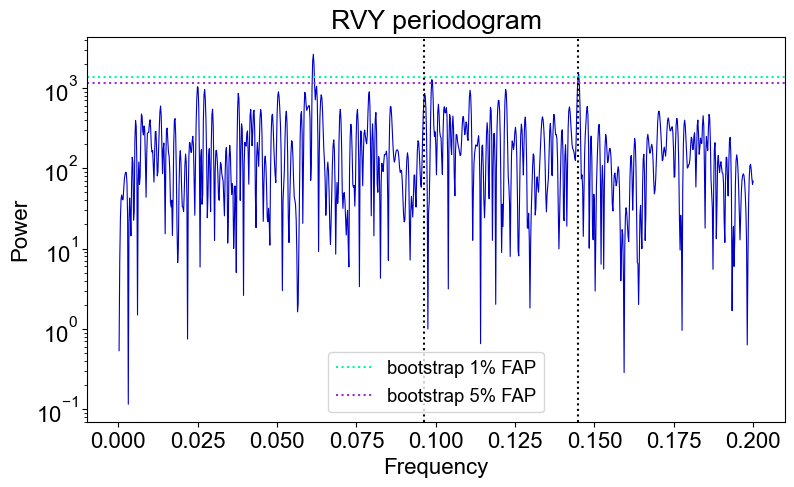

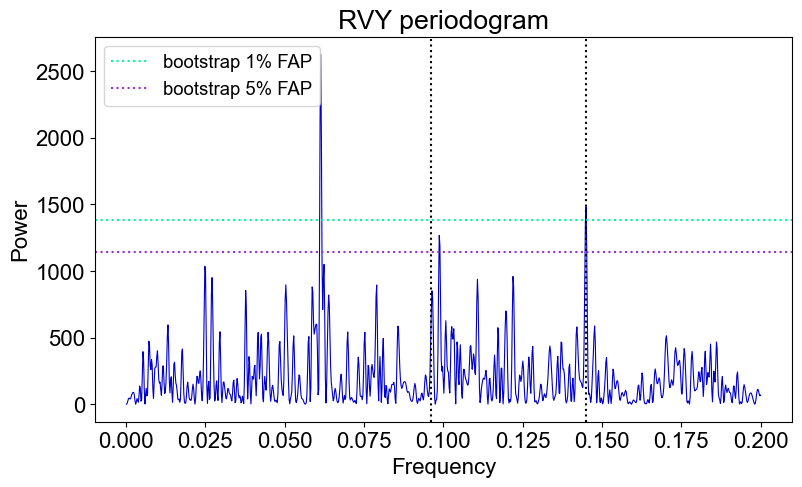

In [24]:
pb = 6.9 # days
pc = 10.4 # days (says possible second planet in paper)
prot = 16.3
planets = [1/pb, 1/pc]
rotation = [1/prot]

ha.powplot(title=r"H$\alpha$ periodogram", vlines=rotation)
rvy.powplot(title='RVY periodogram', vlines=planets)
rvy.powplot(title='RVY periodogram', vlines=planets, yscale='linear')

In [25]:
rvy.Siegel_test()
ha.Siegel_test()

T statistic: 0.01823
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.07189
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [26]:
rvy_ha = Bi.Bivariate(data['BJD'].to_numpy(), data['RVY'].to_numpy(), data['Halpha'].to_numpy())

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152
Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152


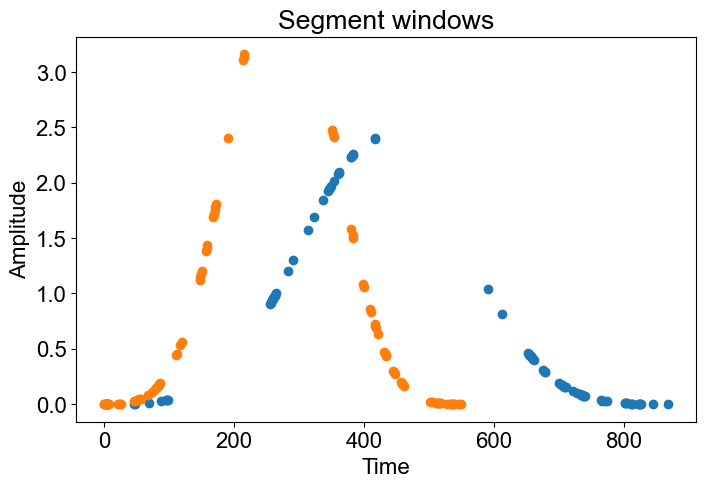

In [27]:
rvy_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

In [28]:
rvy_ha.Welch_coherence_powspec()
rvy_ha.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.180
1% FAP: 0.071
0.1% FAP: 0.011

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.242 crossings =  90.9500 %ile
1% FAP: 0.069 crossings =  50.3850 %ile
0.1% FAP: 0.000 crossings =  90.9500 %ile



In [29]:
rvy_ha.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00952
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


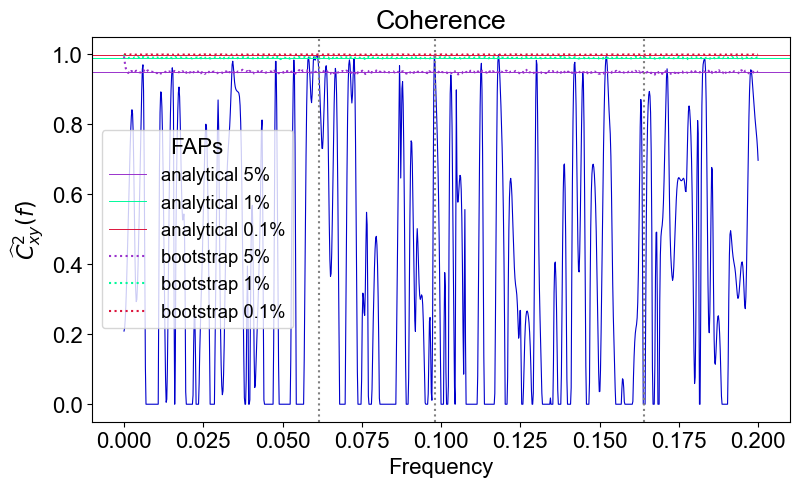

In [30]:
pd = 10.2
pg = 6.1
stellar_signals = [1/prot, 1/pd, 1/pg]
rvy_ha.coh_plot(show_theoretical_thresholds=True, vlines=stellar_signals)

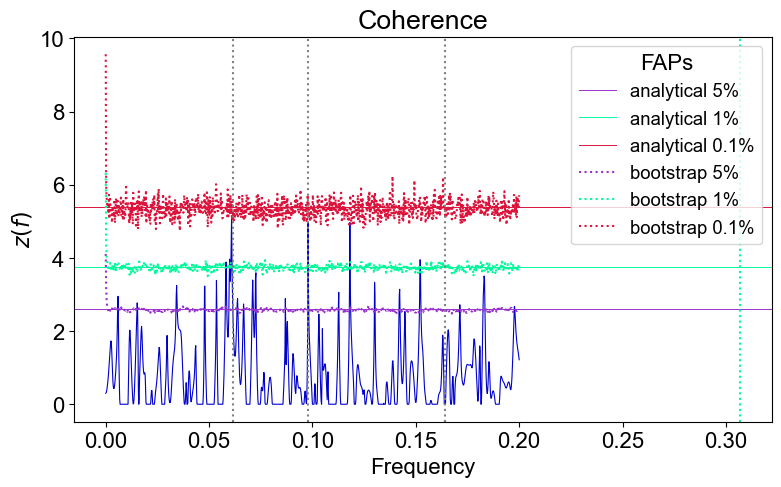

In [31]:
rvy_ha.coh_plot(show_theoretical_thresholds=True, transformed=True, vlines=stellar_signals)
plt.axvline(5/prot, color='mediumspringgreen', ls=':')

Half bandwidth: 0.001734
Welch average spectral window not saved to file
Half bandwidth: 0.001734
Welch average spectral window not saved to file


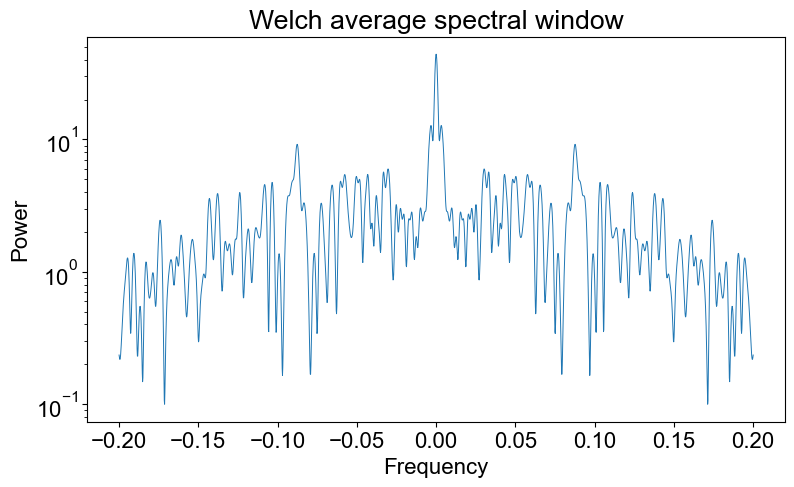

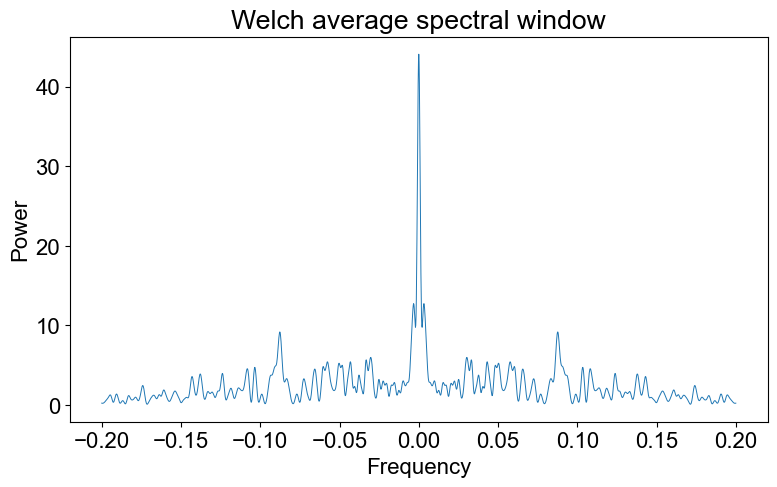

In [32]:
rvy_ha.x_series.spectral_window_Welch()
rvy_ha.x_series.spectral_window_Welch(yscale='linear')

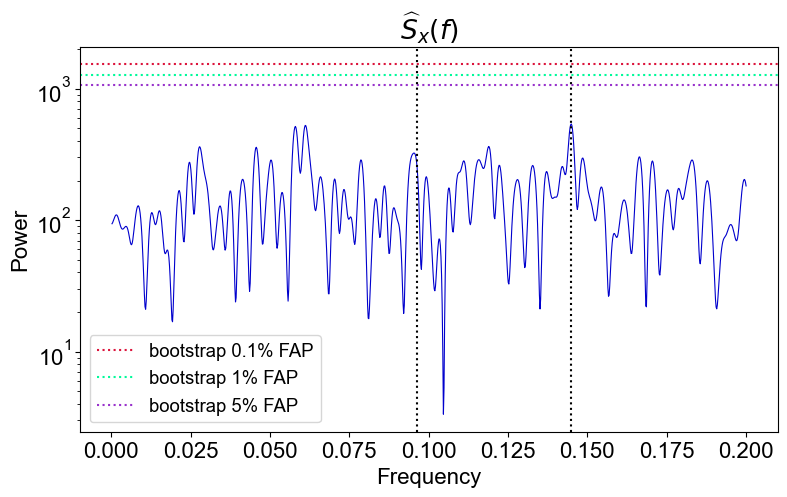

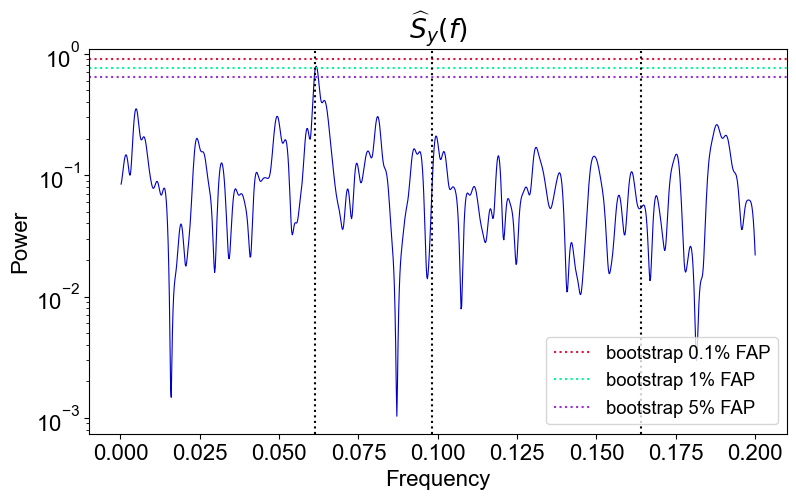

In [33]:
rvy_ha.Welch_pow_plot(vlines=planets)
rvy_ha.Welch_pow_plot(x_or_y='y', vlines=stellar_signals)

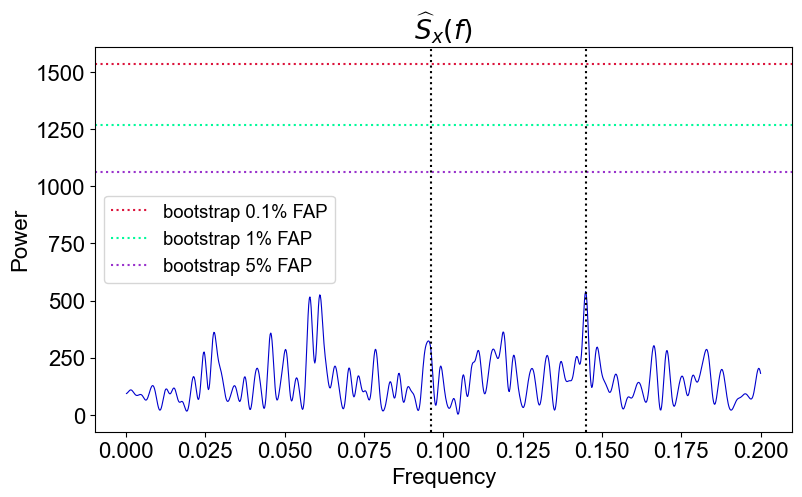

In [34]:
rvy_ha.Welch_pow_plot(vlines=planets, yscale='linear')

In [35]:
pow_ha = LombScargle(data['BJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(rvt_ha.pow_coh_grid)
pow_rvy = LombScargle(data['BJD'].to_numpy(), data['RVT'].to_numpy(), normalization='psd').power(rvt_ha.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [36]:
frot_measured = rvy_ha.y_series.Welch_powgrid[np.argmax(rvy_ha.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 16.21875


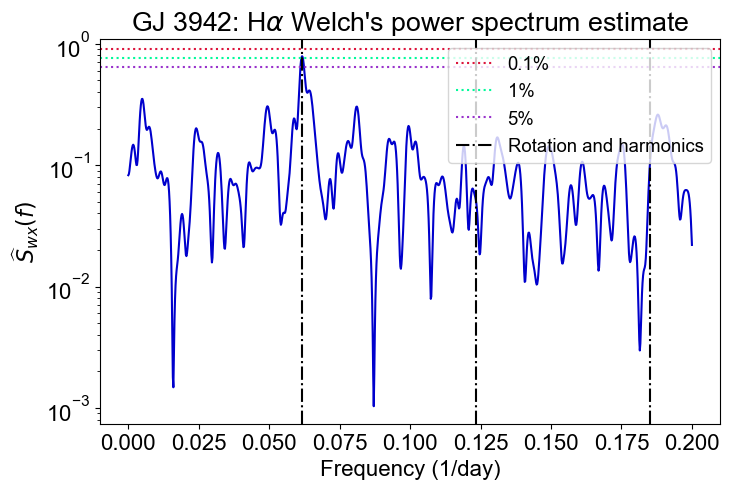

In [37]:
plt.figure(figsize=(8,5))
plt.semilogy(rvy_ha.pow_coh_grid, rvy_ha.y_series.Welch_pow, color='mediumblue')
plt.axhline(rvy_ha.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rvy_ha.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rvy_ha.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
plt.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"GJ 3942: H$\alpha$ Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

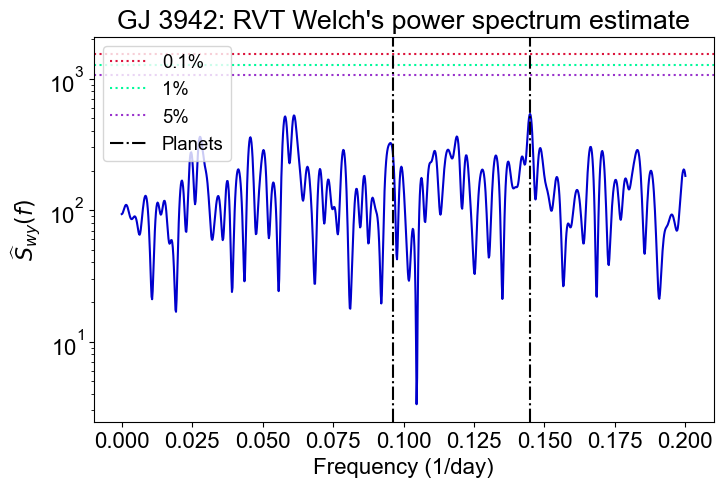

In [38]:
plt.figure(figsize=(8,5))
plt.semilogy(rvy_ha.pow_coh_grid, rvy_ha.x_series.Welch_pow, color='mediumblue')
plt.axhline(rvy_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(rvy_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(rvy_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
plt.axvline(planets[0], color='k', ls='-.', label='Planets')
plt.axvline(planets[1], color='k', ls='-.')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"GJ 3942: RVT Welch's power spectrum estimate")
plt.legend(loc='upper left', fontsize='small')

<font size=10><p style="text-align:center"> S Index & H$\alpha$ </font></p>

In [39]:
ha = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['Halpha'].to_numpy())
s = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['S'].to_numpy(), display_frequency_info=False)

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


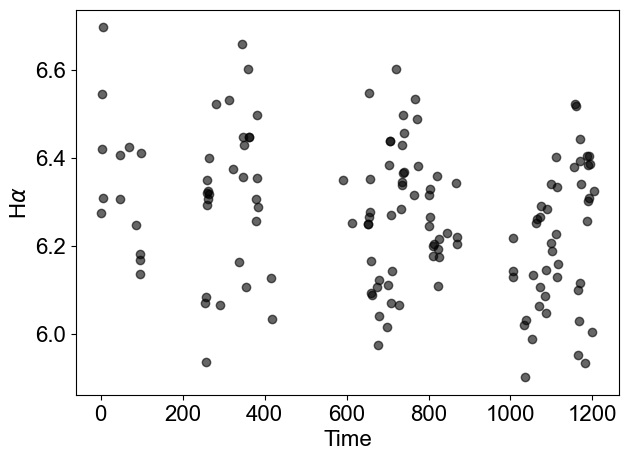

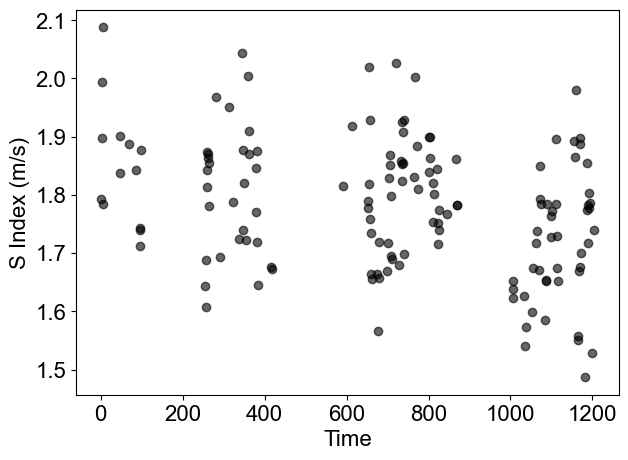

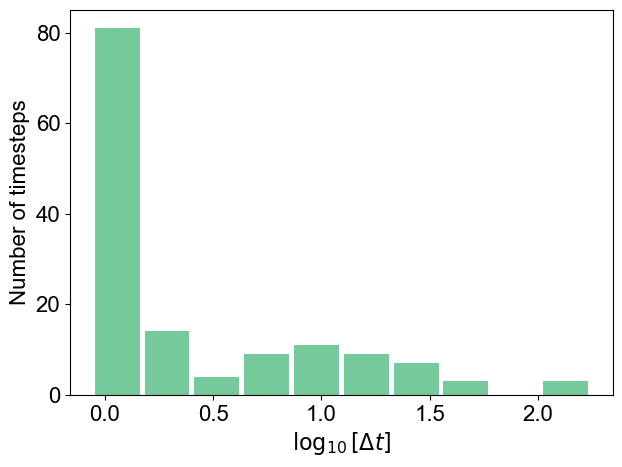

In [40]:
ha.scatterplot(ylabel=r"H$\alpha$")
s.scatterplot(ylabel="S Index (m/s)")
s.dthist()

In [41]:
ha.frequency_grid(0.2)
s.frequency_grid(0.2)

ha.pow_FT(N_bootstrap=2000)
s.pow_FT(N_bootstrap=2000)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


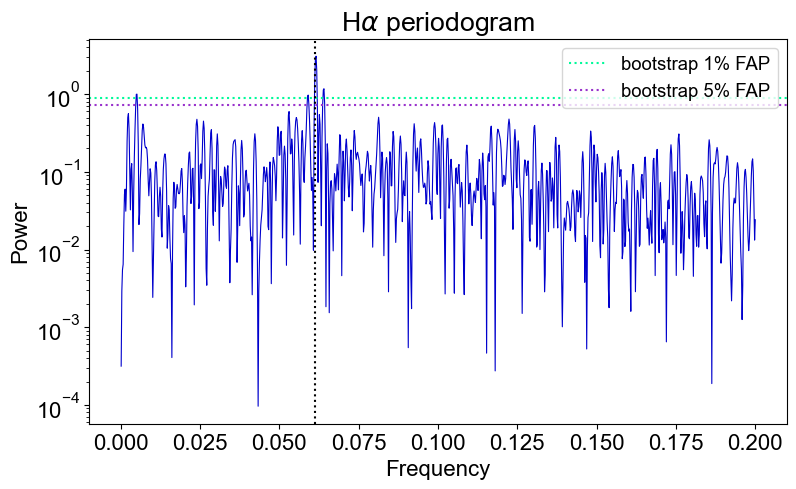

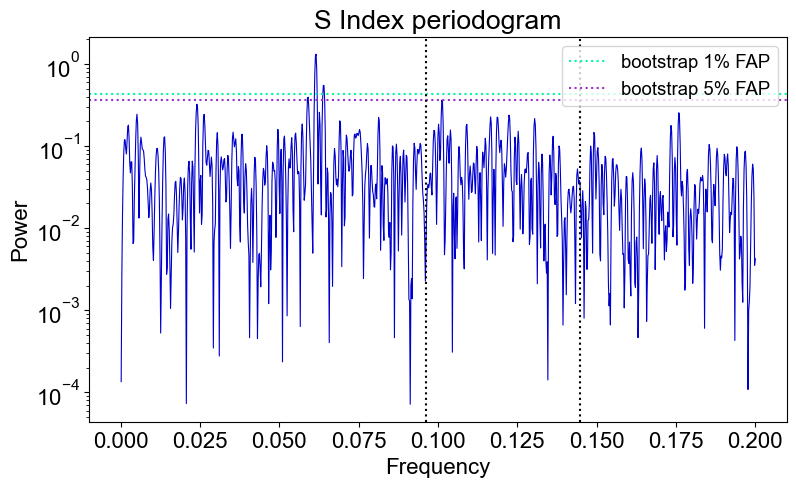

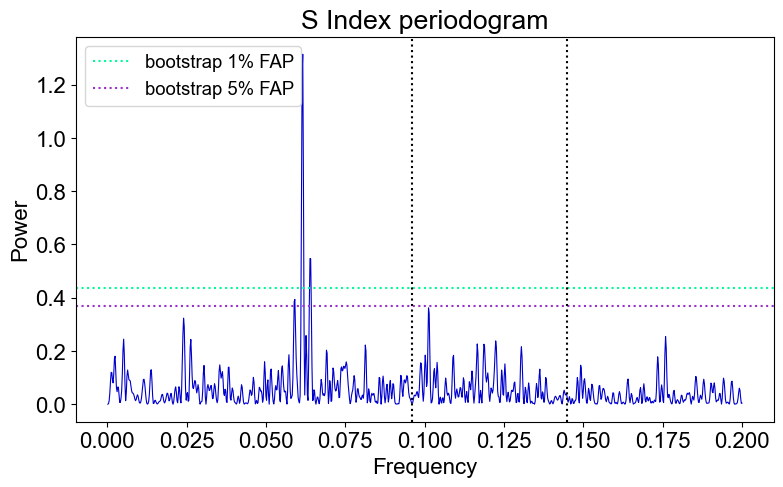

In [42]:
pb = 6.9 # days
pc = 10.4 # days (says possible second planet in paper)
prot = 16.3
planets = [1/pb, 1/pc]
rotation = [1/prot]

ha.powplot(title=r"H$\alpha$ periodogram", vlines=rotation)
s.powplot(title='S Index periodogram', vlines=planets)
s.powplot(title='S Index periodogram', vlines=planets, yscale='linear')

In [43]:
s.Siegel_test()
ha.Siegel_test()

T statistic: 0.05890
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.07189
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [44]:
s_ha = Bi.Bivariate(data['BJD'].to_numpy(), data['S'].to_numpy(), data['Halpha'].to_numpy())

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152
Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152


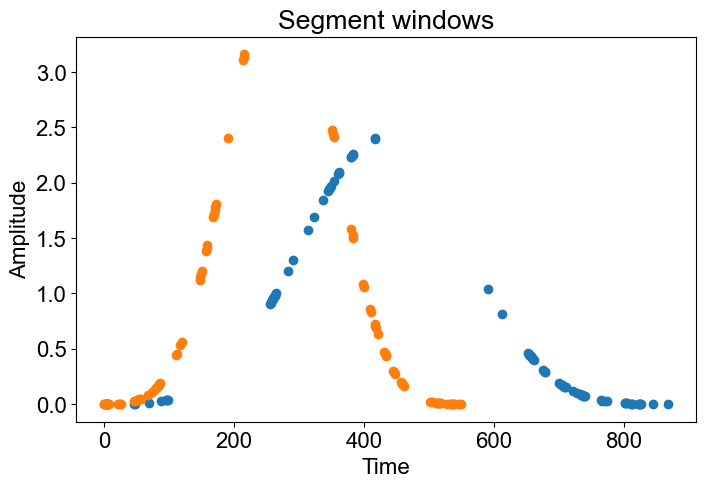

In [45]:
s_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

In [46]:
s_ha.Welch_coherence_powspec()
s_ha.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.179
1% FAP: 0.071
0.1% FAP: 0.011

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.271 crossings =  97.5500 %ile
1% FAP: 0.133 crossings =  97.6050 %ile
0.1% FAP: 0.023 crossings =  97.5500 %ile



In [47]:
s_ha.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00489
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00952
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


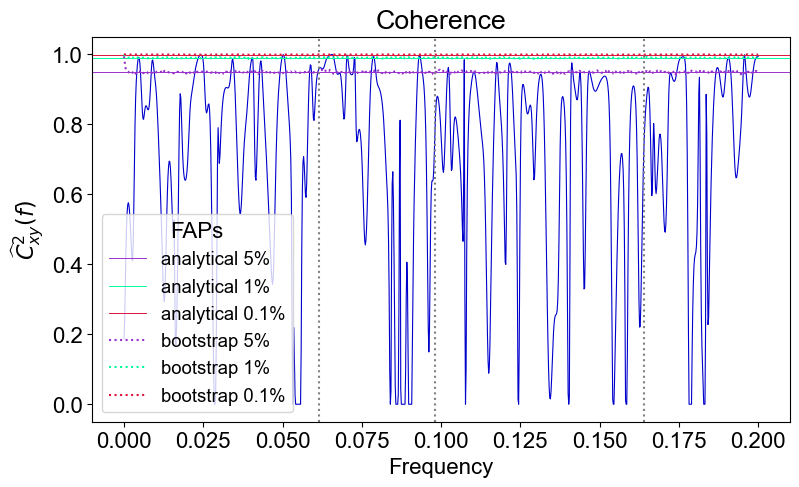

In [48]:
pd = 10.2
pg = 6.1
stellar_signals = [1/prot, 1/pd, 1/pg]
s_ha.coh_plot(show_theoretical_thresholds=True, vlines=stellar_signals)

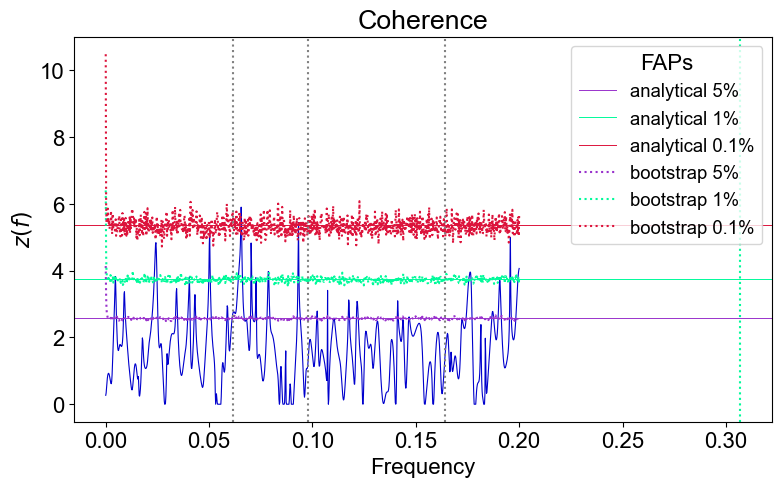

In [49]:
s_ha.coh_plot(show_theoretical_thresholds=True, transformed=True, vlines=stellar_signals)
plt.axvline(5/prot, color='mediumspringgreen', ls=':')

Half bandwidth: 0.001734
Welch average spectral window not saved to file
Half bandwidth: 0.001734
Welch average spectral window not saved to file


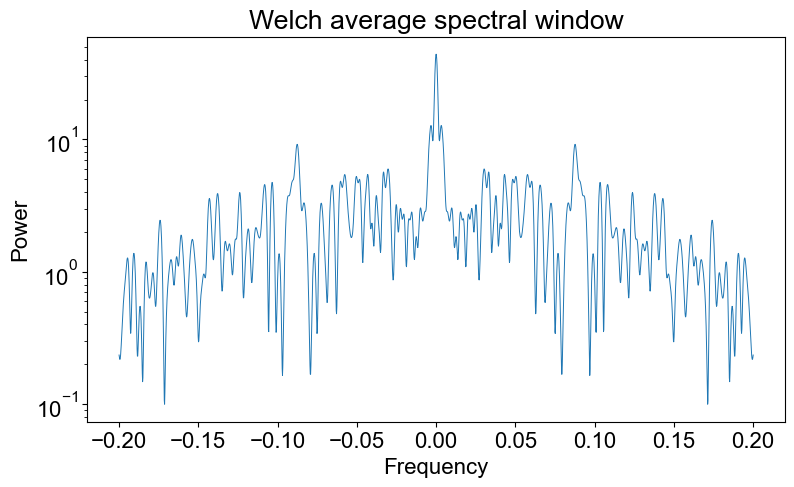

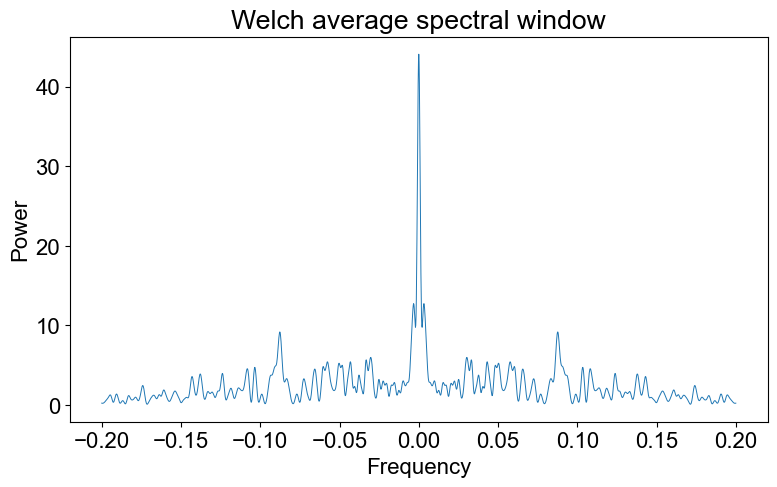

In [50]:
s_ha.x_series.spectral_window_Welch()
s_ha.x_series.spectral_window_Welch(yscale='linear')

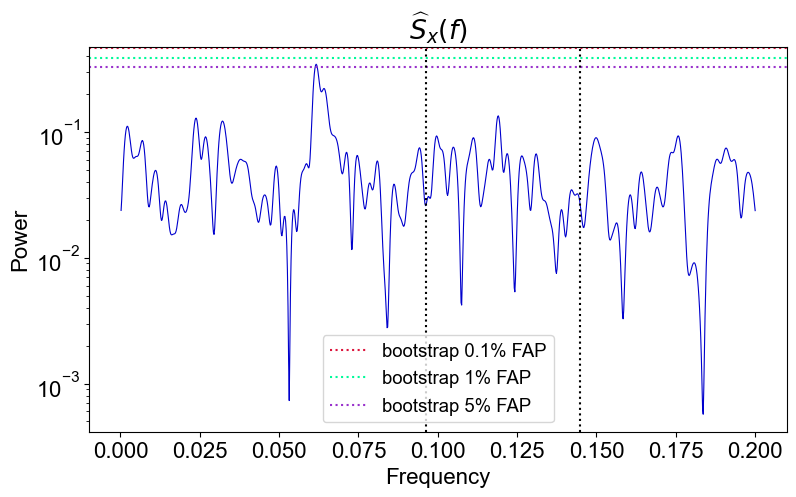

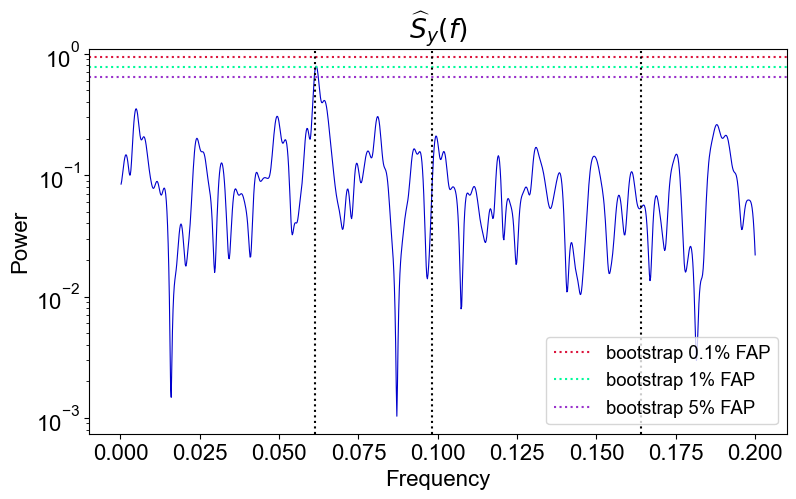

In [51]:
s_ha.Welch_pow_plot(vlines=planets)
s_ha.Welch_pow_plot(x_or_y='y', vlines=stellar_signals)

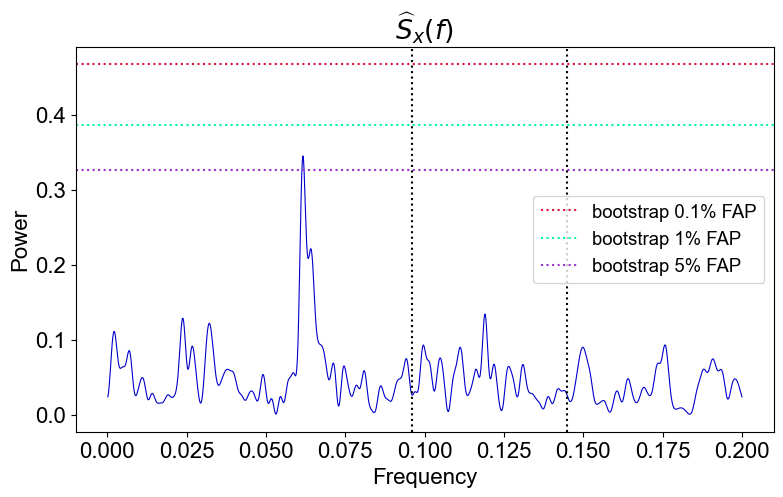

In [52]:
s_ha.Welch_pow_plot(vlines=planets, yscale='linear')

In [53]:
pow_ha = LombScargle(data['BJD'].to_numpy(), data['Halpha'].to_numpy(), normalization='psd').power(s_ha.pow_coh_grid)
pow_s = LombScargle(data['BJD'].to_numpy(), data['S'].to_numpy(), normalization='psd').power(s_ha.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [54]:
frot_measured = s_ha.y_series.Welch_powgrid[np.argmax(s_ha.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 16.21875


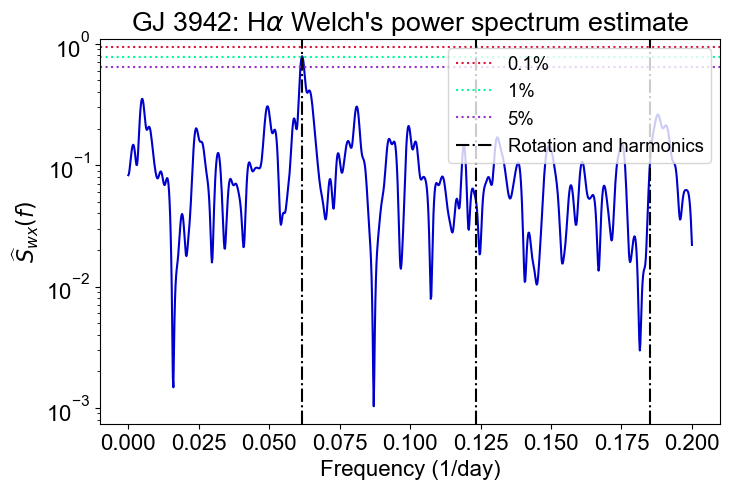

In [55]:
plt.figure(figsize=(8,5))
plt.semilogy(s_ha.pow_coh_grid, s_ha.y_series.Welch_pow, color='mediumblue')
plt.axhline(s_ha.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(s_ha.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(s_ha.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
plt.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"GJ 3942: H$\alpha$ Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

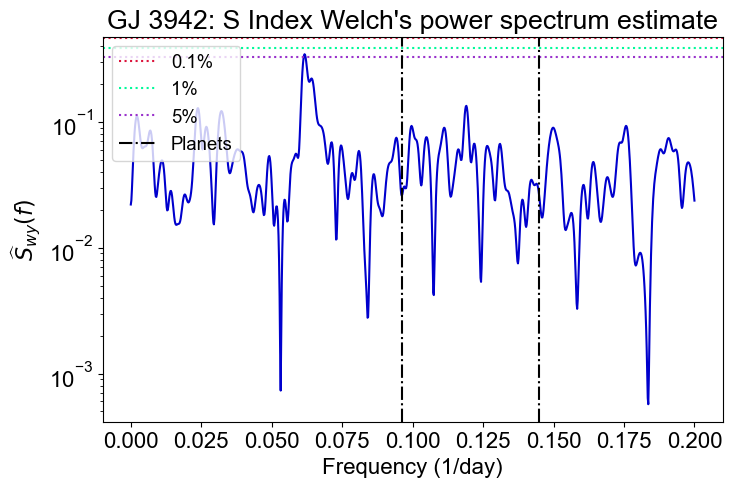

In [56]:
plt.figure(figsize=(8,5))
plt.semilogy(s_ha.pow_coh_grid, s_ha.x_series.Welch_pow, color='mediumblue')
plt.axhline(s_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(s_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(s_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
plt.axvline(planets[0], color='k', ls='-.', label='Planets')
plt.axvline(planets[1], color='k', ls='-.')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"GJ 3942: S Index Welch's power spectrum estimate")
plt.legend(loc='upper left', fontsize='small')

<font size=10><p style="text-align:center"> S Index & RVT </font></p>

In [57]:
rvt = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['RVT'].to_numpy())
s = TimeSeries.TimeSeries(data['BJD'].to_numpy(), data['S'].to_numpy(), display_frequency_info=False)

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


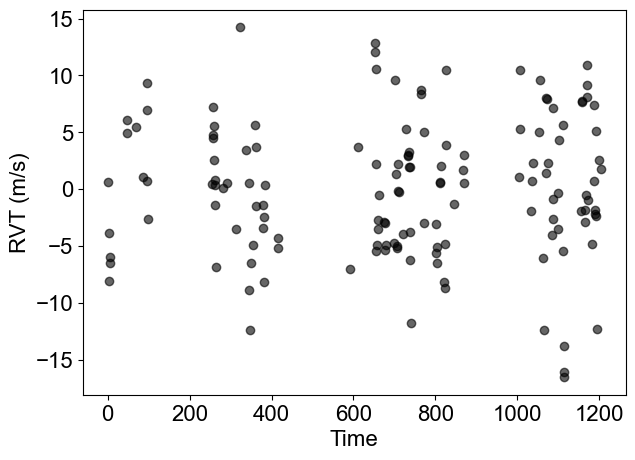

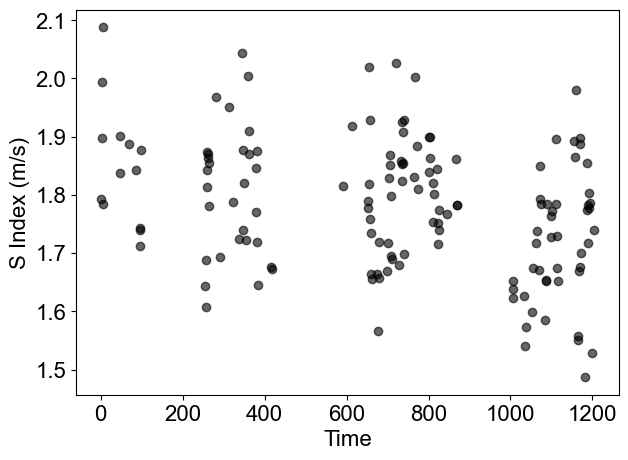

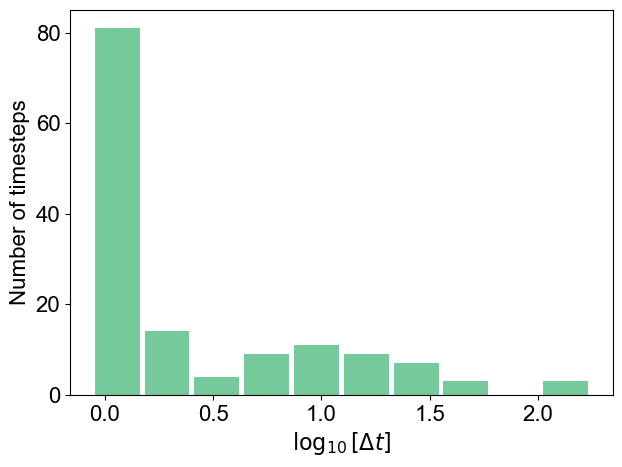

In [58]:
rvt.scatterplot(ylabel="RVT (m/s)")
s.scatterplot(ylabel="S Index (m/s)")
s.dthist()

In [59]:
rvt.frequency_grid(0.2)
s.frequency_grid(0.2)

rvt.pow_FT(N_bootstrap=2000)
s.pow_FT(N_bootstrap=2000)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 0
Iteration 500
Iteration 1000
Iteration 1500


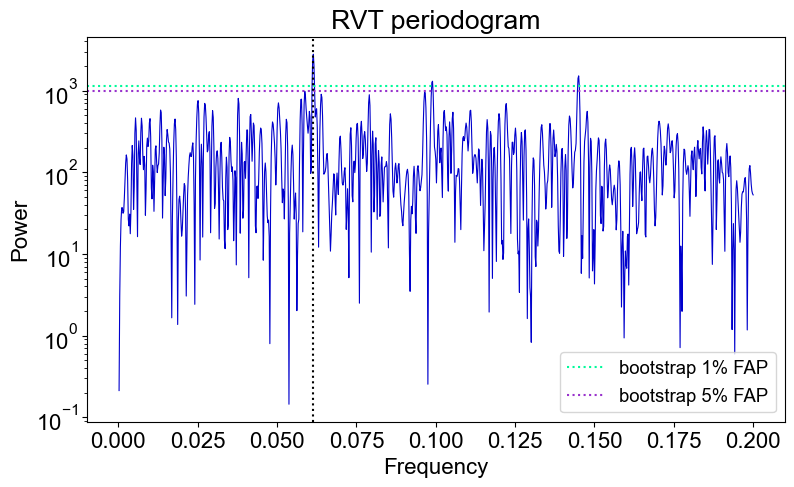

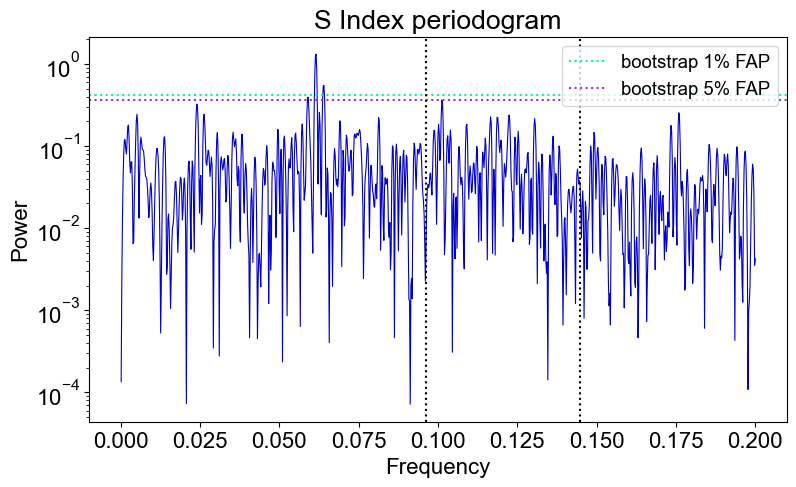

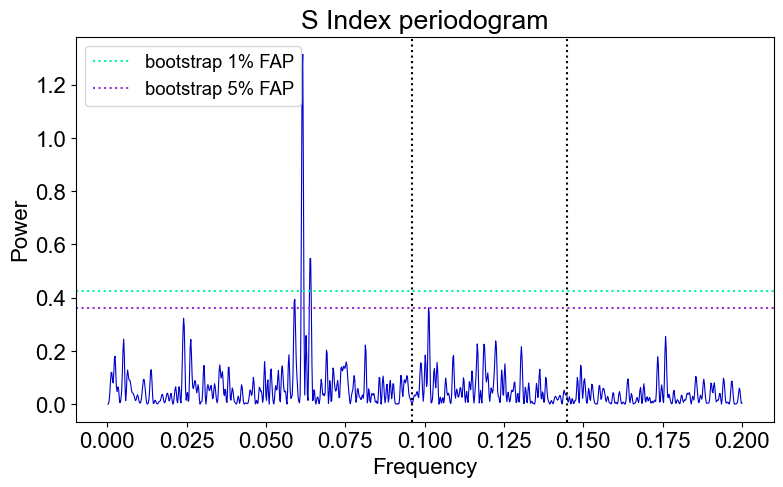

In [60]:
pb = 6.9 # days
pc = 10.4 # days (says possible second planet in paper)
prot = 16.3
planets = [1/pb, 1/pc]
rotation = [1/prot]

rvt.powplot(title="RVT periodogram", vlines=rotation)
s.powplot(title='S Index periodogram', vlines=planets)
s.powplot(title='S Index periodogram', vlines=planets, yscale='linear')

In [61]:
s.Siegel_test()
rvt.Siegel_test()

T statistic: 0.05890
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.03043
T threshold for rejecting white noise hypothesis at 5% level: 0.00716
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [62]:
s_rvt = Bi.Bivariate(data['BJD'].to_numpy(), data['S'].to_numpy(), data['RVT'].to_numpy())

Nyquist frequency from mean dt: 0.05856
Nyquist frequency from 10% trimmed mean dt: 0.11013
Nyquist frequency from 20% trimmed mean dt: 0.14078
Nyquist frequency from median dt: 0.48752
Rayleigh resolution: 0.00083


Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152
Number of data points per segment: 94
Number of segments: 2
Segment start and end points: [[  0  94]
 [ 47 142]]
Effective number of segments: 1.997116
Frequency grid spacing: 0.000193
Minimum 6-dB main lobe half width: 0.003135
Mean 6-dB main lobe half width (1/2 resolution limit): 0.004046
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001152


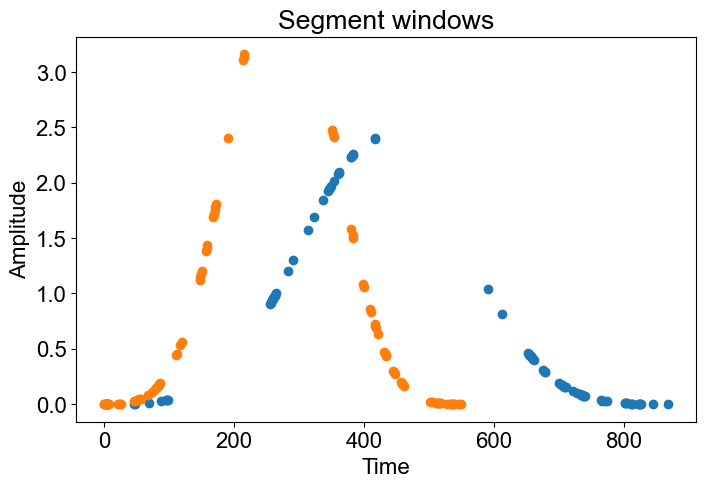

In [63]:
s_rvt.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

In [64]:
s_rvt.Welch_coherence_powspec()
s_rvt.Welch_coherence_powspec_bootstrap()

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500

Mean number of false-alarm threshold crossings per Rayleigh resolution from bootstrap simulations:
5% FAP: 0.180
1% FAP: 0.071
0.1% FAP: 0.011

Number of false-alarm threshold crossings per Rayleigh resolution from actual data:
5% FAP: 0.230 crossings =  86.2450 %ile
1% FAP: 0.092 crossings =  77.2550 %ile
0.1% FAP: 0.012 crossings =  86.2450 %ile



In [65]:
s_rvt.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00489
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00678
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


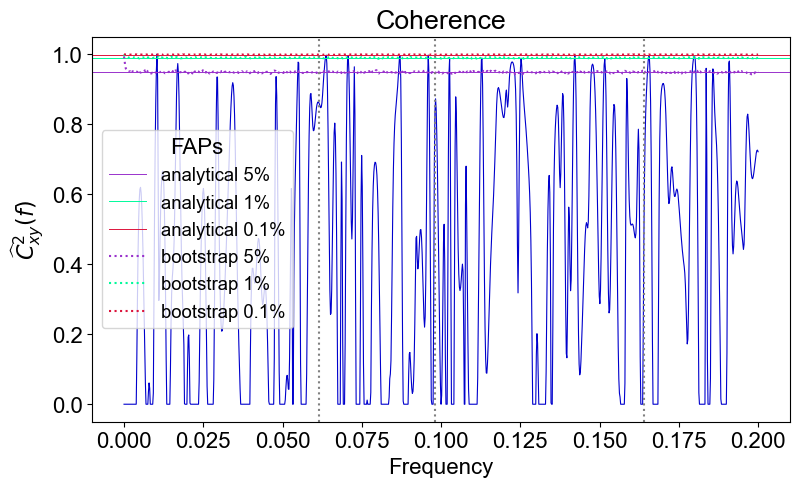

In [66]:
pd = 10.2
pg = 6.1
stellar_signals = [1/prot, 1/pd, 1/pg]
s_rvt.coh_plot(show_theoretical_thresholds=True, vlines=stellar_signals)

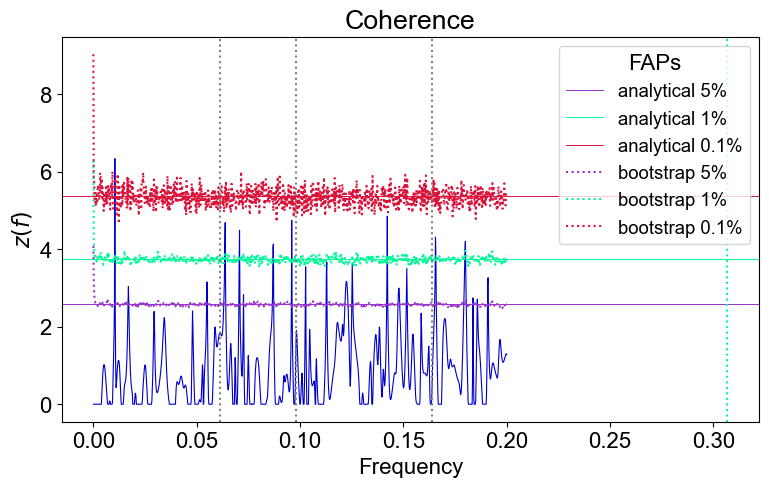

In [67]:
s_rvt.coh_plot(show_theoretical_thresholds=True, transformed=True, vlines=stellar_signals)
plt.axvline(5/prot, color='mediumspringgreen', ls=':')

Half bandwidth: 0.001734
Welch average spectral window not saved to file
Half bandwidth: 0.001734
Welch average spectral window not saved to file


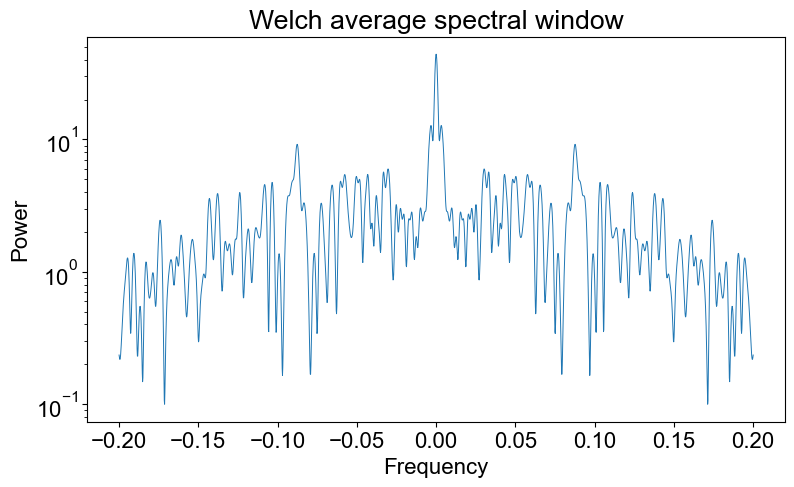

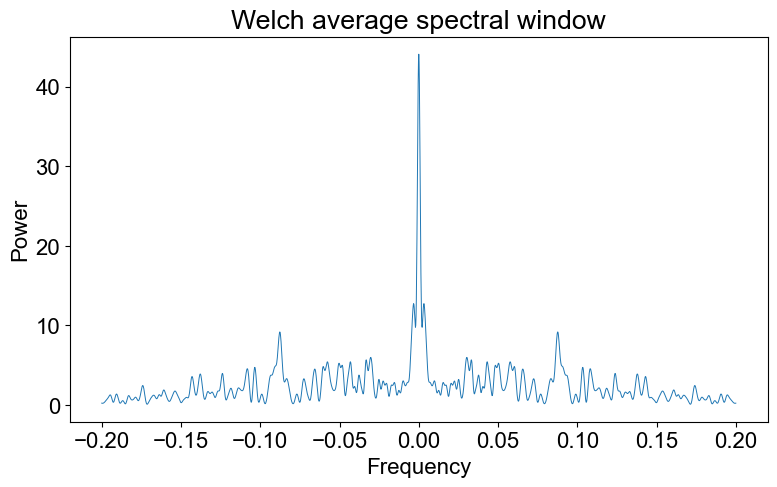

In [68]:
s_rvt.x_series.spectral_window_Welch()
s_rvt.x_series.spectral_window_Welch(yscale='linear')

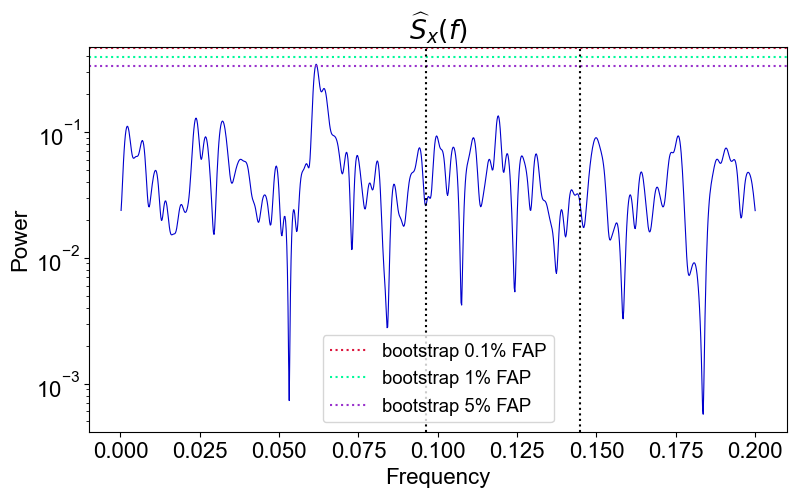

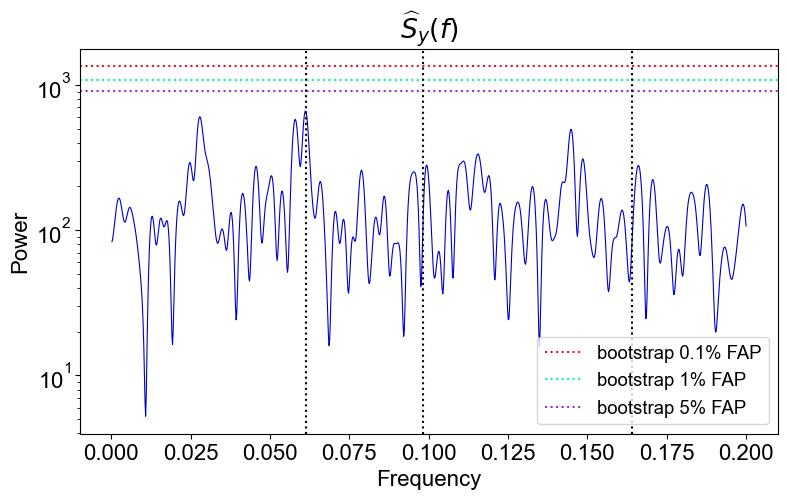

In [69]:
s_rvt.Welch_pow_plot(vlines=planets)
s_rvt.Welch_pow_plot(x_or_y='y', vlines=stellar_signals)

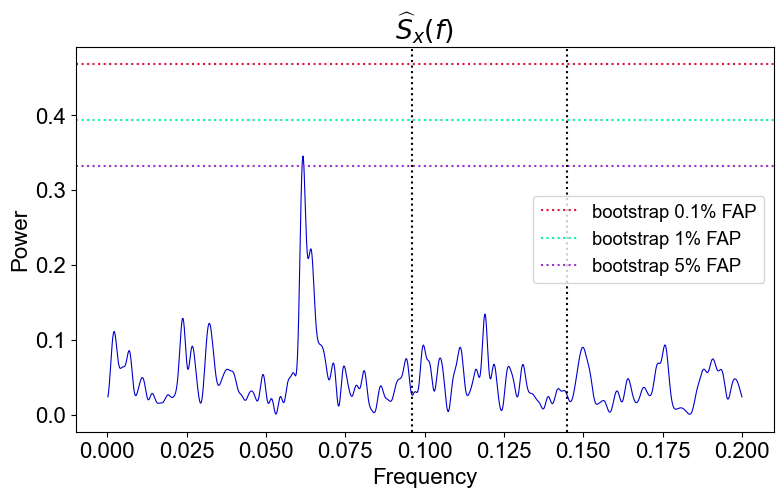

In [70]:
s_rvt.Welch_pow_plot(vlines=planets, yscale='linear')

In [71]:
pow_rvt = LombScargle(data['BJD'].to_numpy(), data['RVT'].to_numpy(), normalization='psd').power(s_rvt.pow_coh_grid)
pow_s = LombScargle(data['BJD'].to_numpy(), data['S'].to_numpy(), normalization='psd').power(s_rvt.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [72]:
frot_measured = s_rvt.y_series.Welch_powgrid[np.argmax(s_rvt.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 16.372239747634076


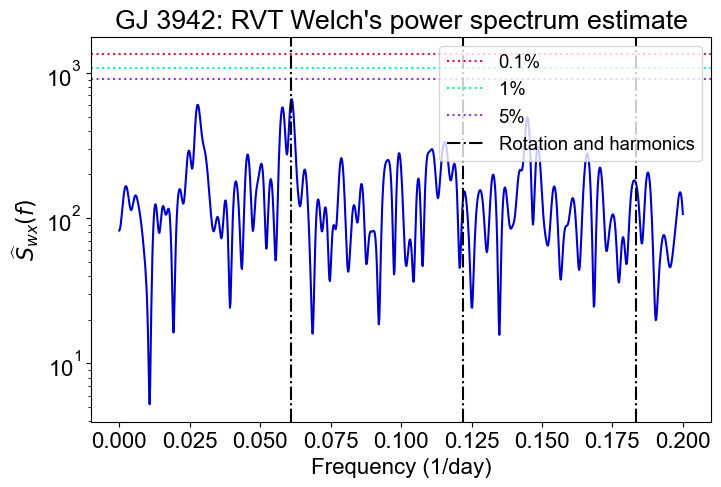

In [73]:
plt.figure(figsize=(8,5))
plt.semilogy(s_rvt.pow_coh_grid, s_rvt.y_series.Welch_pow, color='mediumblue')
plt.axhline(s_rvt.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(s_rvt.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(s_rvt.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
plt.axvline(3*frot_measured, color='k', ls='-.', label='Rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"GJ 3942: RVT Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

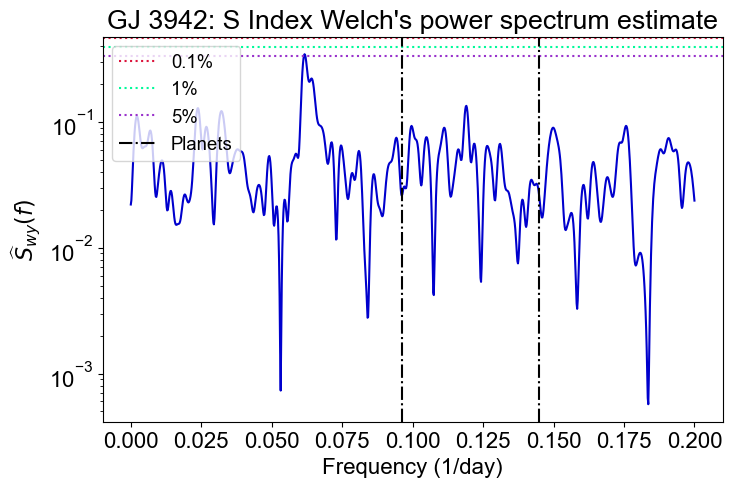

In [74]:
plt.figure(figsize=(8,5))
plt.semilogy(s_rvt.pow_coh_grid, s_rvt.x_series.Welch_pow, color='mediumblue')
plt.axhline(s_rvt.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
plt.axhline(s_rvt.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
plt.axhline(s_rvt.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')
plt.axvline(planets[0], color='k', ls='-.', label='Planets')
plt.axvline(planets[1], color='k', ls='-.')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"GJ 3942: S Index Welch's power spectrum estimate")
plt.legend(loc='upper left', fontsize='small')